# Install Packages

In [ ]:
!pip install itk
#import SimpleITK as sitk
import numpy as np
import os 
import itk
import time
import tensorflow as tf
import pandas as pd

import seaborn as sns
import sys
import glob
from os import listdir
import glob
import tqdm
from typing import Dict
import cv2
import pydicom as dicom
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
import cufflinks

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate, KFold,GroupKFold
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline

ModuleNotFoundError: ignored

# Load Data

Either use API command: kaggle competitions download -c osic-pulmonary-fibrosis-progression
or obtain data from here: https://www.osicild.org/kaggle-challenge.html

In [ ]:
train = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/train.csv")
test = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/test.csv")
train_data = train
test_data = test

In [ ]:
train.describe()

In [ ]:
train.head()

# Data Exploration

In [ ]:
#Figure 1 Generate FVC distribution
sns.distplot(train["FVC"],color="blue")
plt.title("FVC Data Distribution")

In [ ]:
#Figure 2 FVC distribution across sex
for i in train.Sex.unique():
        sns.distplot(train[train['Sex']==i]["FVC"],label=i)
plt.title("FVC Scores Per Sex");
plt.legend();

In [ ]:
#Figure 3 Smoking Status across sex
sns.countplot(data=train,x='SmokingStatus',hue='Sex');
plt.title("Smoking Status across Sex");

In [ ]:
#Figure 4 Using Plotly to show FVC distrubution across sex and smoking status
px.box(train,x="Sex",y="FVC",color="SmokingStatus")

# Image Preprocessing

In [ ]:
train_images = os.listdir('../input/osic-pulmonary-fibrosis-progression/train/') #Change to correct directory

In [ ]:
#Sample DICOM image using pydicom
image = train_image_path+train_images[0]+"/1.dcm"
image = dicom.dcmread(image)
image = image.pixel_array
plt.imshow(image,cmap='gray')

In [ ]:
#Cool Animation Display, function from: https://github.com/pydicom/pydicom/blob/master/examples/image_processing/reslice.py (Credit to: https://www.kaggle.com/maunish)
import matplotlib.animation as animation
from IPython.display import HTML
def show_animation():
    rn = np.random.randint(0,len(train_images),1)[0]
    fig = plt.figure()
    path= train_image_path+train_images[0]
    images = [dicom.read_file(path+"/"+img) for img in os.listdir(path)]
    images.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    ims = list()
    for image in images:
        image = plt.imshow(image.pixel_array,cmap='gray',animated=True)
        plt.axis('off')
        ims.append([image])
    ani = animation.ArtistAnimation(fig,ims,interval=100,blit=False,repeat_delay=1000)
    return ani
ani = show_animation()
HTML(ani.to_jshtml())

In [ ]:
folder_path = '../input/osic-pulmonary-fibrosis-progression'

In [ ]:
#Helper functions from https://www.kaggle.com/maunish
#getting base week for patient
def get_baseline_week(data):
    df = data.copy()
    df['Weeks'] = df['Weeks'].astype(int)
    df['min_week'] = df.groupby('Patient')['Weeks'].transform('min')
    df['baseline_week'] = df['Weeks'] - df['min_week']
    return df

#getting FVC for base week and setting it as base_FVC of patient
def get_base_FVC(data):
    df = data.copy()
    base = df.loc[df.Weeks == df.min_week][['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    base['nb']=1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    base = base[base.nb==1]
    base.drop('nb',axis =1,inplace=True)
    df = df.merge(base,on="Patient",how='left')
    df.drop(['min_week'], axis = 1)
    return df 

In [ ]:
train_data = get_baseline_week(train_data)
train_data = get_base_FVC(train_data)
train_columns = ['baseline_week','base_FVC','Percent','Age','Sex','SmokingStatus']
train_label = ['FVC']
train = train_data[train_columns]

#Preprocess (Z-normalize + 1-Hot encode feature labels)
transformer = ColumnTransformer([('s',StandardScaler(),[0,1,2,3]),('o',OneHotEncoder(),[4,5])])
target = train_data[train_label].values
train = transformer.fit_transform(train)

# Building PyTorch Model

In [ ]:
class Model(nn.Module):
    def __init__(self,n):
        super(Model,self).__init__()
        self.conv = nn.Conv2d(512, 512, (3, 3), stride=(2, 1), padding=(4, 2))
        self.pool = nn.MaxPool2d(3, stride=2)
        self.conv2 = nn.Conv2d(512, 512, (3, 5), stride=(2, 1), padding=(4, 2))
        self.pool2 = nn.MaxPool2d(3, stride=2)
        self.layer1 = nn.Linear(n,200)
        self.layer2 = nn.Linear(200,100)
        
        self.out1 = nn.Linear(100,3)
        self.relu3 = nn.ReLU()
        self.out2 = nn.Linear(100,3)
            
    def forward(self,xb):
        x1 =  F.leaky_relu(self.layer1(xb))
        x1 =  F.leaky_relu(self.layer2(x1))
        
        o1 = self.out1(x1)
        o2 = F.relu(self.out2(x1))
        return o1 + torch.cumsum(o2,dim=1)

In [ ]:
#run the model, note only 1 fold used in actual test, very slow using cpu
def run():
    
    def score(outputs,target):
        confidence = outputs[:,2] - outputs[:,0]
        clip = torch.clamp(confidence,min=70)
        target=torch.reshape(target,outputs[:,1].shape)
        delta = torch.abs(outputs[:,1] - target)
        delta = torch.clamp(delta,max=1000)
        sqrt_2 = torch.sqrt(torch.tensor([2.])).to(device)
        metrics = (delta*sqrt_2/clip) + torch.log(clip*sqrt_2)
        return torch.mean(metrics)
    
    def qloss(outputs,target):
        qs = [0.25,0.5,0.75]
        qs = torch.tensor(qs,dtype=torch.float).to(device)
        e =  target - outputs
        e.to(device)
        v = torch.max(qs*e,(qs-1)*e)
        v = torch.sum(v,dim=1)
        return torch.mean(v)
    
    def loss_fn(outputs,target,l):
        return l * qloss(outputs,target) + (1- l) * score(outputs,target)
        
    def train_loop(train_loader,model,loss_fn,device,optimizer,lr_scheduler=None):
        model.train()
        losses = list()
        metrics = list()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):           
                outputs = model(inputs)                 
                metric = score(outputs,labels)

                loss = loss_fn(outputs,labels,0.8)
                metrics.append(metric.cpu().detach().numpy())
                losses.append(loss.cpu().detach().numpy())

                loss.backward()

                optimizer.step()
                if lr_scheduler != None:
                    lr_scheduler.step()
            
        return losses,metrics
    
    def valid_loop(valid_loader,model,loss_fn,device):
        model.eval()
        losses = list()
        metrics = list()
        for i, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)                 
            metric = score(outputs,labels)
            
            loss = loss_fn(outputs,labels,0.8)
            metrics.append(metric.cpu().detach().numpy())
            losses.append(loss.cpu().detach().numpy())
            
        return losses,metrics    

    NFOLDS =5
    kfold = KFold(NFOLDS,shuffle=True,random_state=42)
    
    #kfold
    for k , (train_idx,valid_idx) in enumerate(kfold.split(train)):
        batch_size = 64
        epochs = 50
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"{device} is used")
        x_train,x_valid,y_train,y_valid = train[train_idx,:],train[valid_idx,:],target[train_idx],target[valid_idx]
        n = x_train.shape[1]
        model = Model(n)
        model.to(device)
        lr = 0.1
        optimizer = optim.Adam(model.parameters(),lr=lr)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

        train_tensor = torch.tensor(x_train,dtype=torch.float)
        y_train_tensor = torch.tensor(y_train,dtype=torch.float)

        train_ds = TensorDataset(train_tensor,y_train_tensor)
        train_dl = DataLoader(train_ds,
                             batch_size = batch_size,
                             num_workers=4,
                             shuffle=True
                             )

        valid_tensor = torch.tensor(x_valid,dtype=torch.float)
        y_valid_tensor = torch.tensor(y_valid,dtype=torch.float)

        valid_ds = TensorDataset(valid_tensor,y_valid_tensor)
        valid_dl = DataLoader(valid_ds,
                             batch_size = batch_size,
                             num_workers=4,
                             shuffle=False
                             )
        
        print(f"Fold {k}")
        for i in range(epochs):
            losses,metrics = train_loop(train_dl,model,loss_fn,device,optimizer,lr_scheduler)
            valid_losses,valid_metrics = valid_loop(valid_dl,model,loss_fn,device)
            if (i+1)%5==0:
                print(f"epoch:{i} Training | loss:{np.mean(losses)} score: {np.mean(metrics)}| \n Validation | loss:{np.mean(valid_losses)} score:{np.mean(valid_metrics)}|")
        torch.save(model.state_dict(),f'model{k}.bin')

# Predictions

In [ ]:
def inference():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    nfold = 5
    all_prediction = np.zeros((test.shape[0],3))
    
    for i in range(nfold):
        n = train.shape[1]
        
        model = Model(n)
        model.load_state_dict(torch.load(f"model{i}.bin"))
        predictions = list()
        model.to(device)
        test_tensor = torch.tensor(test,dtype=torch.float)
        test_dl = DataLoader(test_tensor,
                        batch_size=64,
                        num_workers=2,
                        shuffle=False)
    
        with torch.no_grad():
            for i, inputs in enumerate(test_dl):
                inputs = inputs.to(device, dtype=torch.float)
                outputs= model(inputs) 
                predictions.extend(outputs.cpu().detach().numpy())

        all_prediction += np.array(predictions)/nfold
        
    return all_prediction  

In [ ]:
prediction = inference()

# Trial

In [ ]:
epoch = [4,9,14,19,24,29,34,39,44,49]
log_loss_train = [170.82,133.61, 129.40, 126.47, 134.14, 127.55, 125.13, 126.66, 130.43, 129.05]
log_loss_val = [160.25, 146.13, 145.25, 145.04, 145.06,145.06,145.06,145.06, 145.06,145.06 ]
mse_train = [6862.55, 6748.23, 6744.57, 6688.92, 6703.33, 6710.01, 6709.94, 6705.69, 6696.48, 6705.46]
mse_val = [6706.52, 6778.78, 6763.13, 6762.22, 6763.00, 6763.05, 6763.05,6763.05,6763.05,6763.05]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

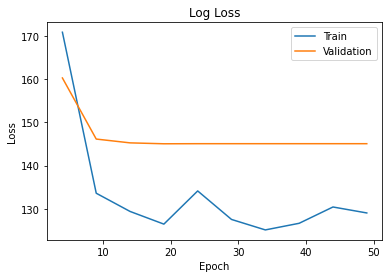

In [ ]:
plt.plot(epoch, log_loss_train, label = "Train");
plt.plot(epoch, log_loss_val, label = "Validation");
plt.title("Log Loss");
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.legend();

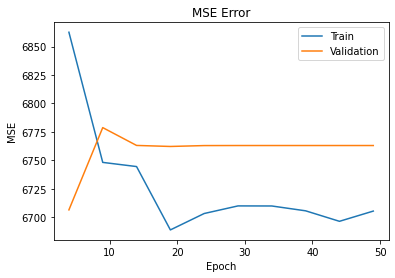

In [ ]:
plt.plot(epoch, mse_train, label = "Train");
plt.plot(epoch, mse_val, label = "Validation");
plt.title("MSE Error");
plt.xlabel("Epoch");
plt.ylabel("MSE");
plt.legend();